<a href="https://colab.research.google.com/github/abyanjan/Fine-Tune-BERT-for-Text-Classification/blob/master/Fine_tune_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FINE TUNIG BERT FOR TWITTER SENTIMENT CLASSIFICATION WITH HUGGING FACE TRANSFORMERS AND TENSORFLOW

### Read and Explore Data

读取数据并且做一定的可视化，如果出现非平衡的数据可能需要调整，做one-classification model 或者 采样方法创造数据（不太推荐）

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import  nltk
import re


In [6]:
pd.__version__

'2.2.3'

In [2]:
data=pd.read_csv(r'c:\Users\Hero Stephen\Desktop\咸鱼\label_data.csv')

In [54]:
data=data[['Description','First tag']]

In [55]:
data=data[data['First tag']!=0]

In [3]:
#数据清洗的过程
def clean_text_simple(text):
    stopwords=nltk.corpus.stopwords.words('english')
    if not isinstance(text, str):
        return ""

    # 只保留 字母、数字、空格、基本标点（.,!?）
    cleaned = re.sub(r'[^\w\s.,!?]', ' ', text)
    cleaned = re.sub(r'\s+', ' ', cleaned)

    # 剔除超长乱码（假设>15个连续字母/数字是乱码）
    cleaned = ' '.join(
        word for word in cleaned.split()
        if len(word) <= 15 and re.match(r'^[a-zA-Z0-9.,!?]+$', word) and word not in stopwords
    )

    return cleaned.strip()

In [57]:
data['Description']=data['Description'].apply(lambda x:clean_text_simple(x))

In [60]:
data['Description'][6]

'I love headphones. Sadly days ago volume power button would register unless I pushed hard even hit miss. I willing live yesterday cover flap came loose snagged hair I removing head cover came off. I tried place back place seems vital piece broke I believe could initial problem button jammed well. Thank guys products awesome I complaints. Just want wonderful headphones back.'

In [61]:
data['First tag'].unique()

array(['Brand', 'Product Issue', 'Follow up', 'Fulfillment', nan,
       'Transaction', 'Policy', 'Shokz App/Shokz Connect', 'Feedback',
       'BPI (Basic Product Information)', 'Risky Issue', 'BPI', '0'],
      dtype=object)

In [12]:
from sklearn.preprocessing import LabelEncoder

#转换数值类型
data['First tag']=LabelEncoder().fit_transform(data['First tag'])

In [16]:
train_df=data[:int(len(data)*0.8)]
test_df=data[int(len(data)*0.8):]

In [10]:
train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')

In [11]:
# check the size of the data
print("Train data size \n", train_df.shape )
print()
#print("Test data size \n", test_df.shape )

Train data size 
 (7613, 5)



In [12]:
# check data sample
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


数据集就是text,target这种就足够了，由于这种方法使用的是tensorflow，所以数据不用进行批量操作

In [14]:
#test_df.head()

We see that for test data we do not have the 'target' columns. We will need to predict the target for the test data and submit to kaggle to check for our score.

So, for the rest of the part , we will be only working with the train data to train our model.

In [13]:
# checking for any duplicates in the text columns
train_df['text'].duplicated().sum()

110

In [ ]:
# dropping the duplicates，总是删除重复值的第一个

train_df.drop_duplicates('text', keep='first')
train_df.shape

(7613, 5)

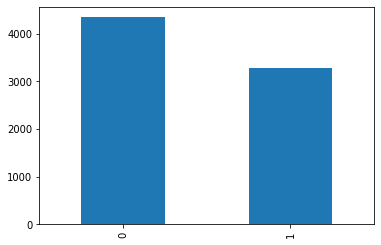

In [15]:
# checking the target distribution
train_df.target.value_counts().plot(kind = 'bar')

We see that there is a balanaced distribution of the target levels.

In [16]:
# checking some of the positive disaster tweets
for i in range(5):
  print(train_df[train_df.target==1]['text'].iloc[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [17]:
# checking some of the neagtive disaster tweets
for i in range(5):
  print(train_df[train_df.target==0]['text'].iloc[i])

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


In [18]:
# Exploring the text lengths
textlen = train_df['text'].apply(lambda x: len(x.split()))

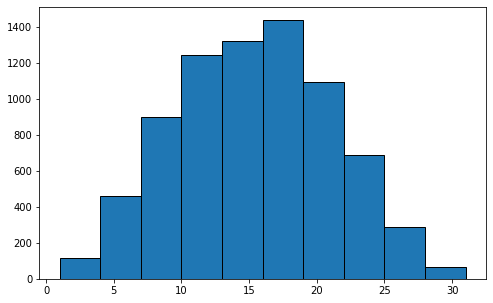

In [19]:
# vsualize the text length
import seaborn as sns
plt.figure(figsize=(8,5))
plt.hist(textlen, edgecolor = "black");

We can set the maximum sequence length as 30, for training our bert model.

需要考虑句子长短，多少个单词，决定Sequence length的长度

In [62]:


SEQ_LEN = 56

导入tokenizer，tokenizer可以帮助我们词向量转换，这一步也叫微调，因为huggingface上的模型是预训练好的，用他们自己的数据训练好的，我们这一步就是将已有的模型进行微调，适合我们这个的小任务

In [5]:
from transformers import BertTokenizer
from transformers import AutoTokenizer
import tensorflow as tf

In [6]:
# download the tokenizer
#task = "sentiment"
#直接从网站上找模型导入即可
#MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
#tokenizer = AutoTokenizer.from_pretrained(MODEL, do_lower_case = True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Before tokenizing the text, we can do some text cleaning to remove the user name and any http links in the tweet text.

In [ ]:
# 文本清洗，可以搭配在voc项目中那个进行一同清洗
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace("#","")
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")

In [96]:
train_df['text'] = train_df['text'].apply(preprocess)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


**Encoding the text for Bert model**

In [97]:
# example of tokenization
tokenizer.tokenize(preprocess("Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"))

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

In [98]:
# example of an output from encoded text by tokeneizer
encoded_input = tokenizer(preprocess("Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"))
print(encoded_input)

{'input_ids': [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 8372, 2089, 16455, 9641, 2149, 2035, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [99]:
tokenizer.decode(encoded_input['input_ids'])

'[CLS] our deeds are the reason of this earthquake may allah forgive us all [SEP]'

In [65]:
# encoding the training data
train_encoded_inputs = tokenizer(train_df['Description'].to_list(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')


In [66]:
train_encoded_inputs

{'input_ids': <tf.Tensor: shape=(11448, 56), dtype=int32, numpy=
array([[  101,  4931,  3539, ..., 15386,  5549,   102],
       [  101,  2122,  5592, ...,     0,     0,     0],
       [  101,  4931, 26822, ...,  5227,  1010,   102],
       ...,
       [  101,  2157,  4540, ...,     0,     0,     0],
       [  101,  1039,  2595, ...,     0,     0,     0],
       [  101,  2097, 17048, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(11448, 56), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

**Creating Tensorflow data**

In [67]:
#创建数据集
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train_df['First tag'].values))

In [6]:
# formatting the data as required by bert model
def map_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}
  
  return inputs, labels

In [69]:
train_dataset = train_dataset.map(map_bert)

In [24]:
for t in train_dataset.take(2):
  print (t)

({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  4931,  3539,  2154, 16798,  2629,  3517,  2718,  3054,
        2251,  5026,  4400,  4497,  7347,  2593, 12992, 10385, 12475,
        5166,  4810,  1012,  3251, 12106,  2242,  2047, 25169, 24304,
        2015,  1010,   102])>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])>}, <tf.Tensor: shape=(), dtype=int32, numpy=3>)
({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  2122,  5592, 11194,  1045,  5309, 24306,  1010,  4435,
        2047,  4156, 11194,  9733,  1012,  1996,  2187,  2217,  2843,
       10763,  2652,  2614,  1012,   102,     0,     0,     0,     0,
           0,     0,     0])>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0])>}, <tf.Tensor:

**微调** 

In [2]:
from datasets import load_dataset

# 加载数据集 (这里使用IMDB影评数据集)
dataset = load_dataset('imdb')
train_dataset = dataset['train'].select(range(100))
eval_dataset = dataset['test'].select(range(20))





In [3]:
from transformers import BertTokenizer

# 加载BERT的分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 预处理函数
def preprocess_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=256,
        return_tensors="pt",
        padding=True
    )

# 应用预处理
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_eval = eval_dataset.map(preprocess_function, batched=True)

In [4]:
#上一步是将text转换成input_ids，下面是文本分类预训练模型

from transformers import BertForSequenceClassification
from transformers import DataCollatorWithPadding


data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='pt')

# 加载模型（指定类别数）
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # 二分类任务
)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1]:
from transformers import TrainingArguments, Trainer


#可以自己修改超参数
training_args = TrainingArguments(
    output_dir='./results',          # 输出目录
    num_train_epochs=3,              # 训练轮数
    per_device_train_batch_size=8,   # 训练批次大小
    per_device_eval_batch_size=16,   # 评估批次大小
    learning_rate=2e-5,              # 学习率（BERT微调的典型值）
    weight_decay=0.01,               # 权重衰减
    evaluation_strategy="epoch",     # 每个epoch后评估
    save_strategy="epoch",           # 每个epoch后保存
    logging_dir='./logs',            # 日志目录
    logging_steps=50,
    load_best_model_at_end=True,     # 训练结束时加载最佳模型
    metric_for_best_model="accuracy" # 评估指标
    )

#创建评估指标
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics,
    data_collator=data_collator

)

# 开始训练
trainer.train()


# 保存模型
model.save_pretrained("./my_finetuned_bert")

# 使用模型进行预测
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="./my_finetuned_bert",
    tokenizer=tokenizer
)

print(classifier("This movie was absolutely fantastic!"))



d:\Anaconda\envs\aotu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_utils because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

**Creating train and test split**

In [70]:
#打乱数据并且区分成64个批次
dataset = train_dataset.shuffle(100000).batch(64)

In [71]:
# length of the dataset(total batches)
DS_LEN = len(dataset)
DS_LEN

179

In [72]:
# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

**Modeling**

In [8]:
from transformers import TFAutoModel

In [9]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [75]:


# Input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

# keras layers
#x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# output layer——双变量
# y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

#多变量
y = tf.keras.layers.Dense(13, activation='softmax')(x)

# create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [76]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 56)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 56)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 56, 76                                     

In [77]:
#让bert层不参与训练
model.layers[2].trainable = False
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 56)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 56)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 56, 76                                     

**Compile model**

In [34]:
import transformers

In [78]:
#learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
#optimizer = transformers.AdamWeightDecay(learning_rate=5e-4)
loss = tf.keras.losses.sparse_categorical_crossentropy
metric = tf.keras.metrics.sparse_categorical_accuracy

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [79]:
# train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 5,
    callbacks = callbacks
)

Epoch 1/5
 93/143 [==================>...........] - ETA: 1:33 - loss: 1.4826 - sparse_categorical_accuracy: 0.5496

KeyboardInterrupt: 

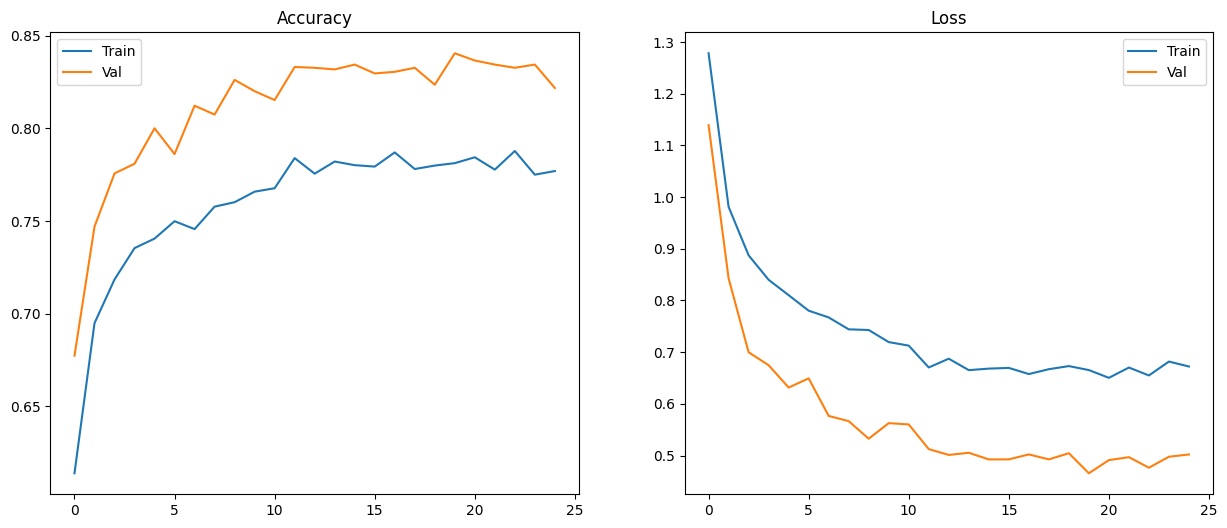

In [50]:
# plot the performance curve
epochs = history.epoch
plt.figure(figsize=(15, 6))

# Accuracy
plt.subplot(1,2, 1)
plt.plot(epochs, history.history['sparse_categorical_accuracy'], label="Train")
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], label = "Val")
plt.legend()
plt.title("Accuracy")

# loss
plt.subplot(1,2, 2)
plt.plot(epochs, history.history['loss'], label="Train")
plt.plot(epochs, history.history['val_loss'], label = "Val")
plt.legend()
plt.title("Loss")

plt.show()

In [51]:
# evaluate on val data
model.evaluate(val_ds)

36/36 [==============================] - 27s 744ms/step - loss: 0.4958 - sparse_categorical_accuracy: 0.8293


[0.4958331286907196, 0.8292682766914368]

### 预测

In [126]:
test_df = pd.read_csv('test.csv')

In [127]:
# clean text
test_df['text'] = test_df['text'].apply(preprocess)

In [128]:
# encoding the test data
test_encoded_inputs = tokenizer(test_df['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [129]:
# create tf dataset
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encoded_inputs))


In [130]:
test_dataset

<TensorSliceDataset shapes: {input_ids: (30,), attention_mask: (30,)}, types: {input_ids: tf.int32, attention_mask: tf.int32}>

In [131]:
for d in train_dataset.take(1):
  print (d)

({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  8372,
        2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [132]:
# make prediction
test_ds = test_dataset.shuffle(100000).batch(64)
test_pred = model.predict(test_ds)

In [133]:
test_pred

array([[0.9743454 ],
       [0.9379656 ],
       [0.8759267 ],
       ...,
       [0.34330094],
       [0.68898344],
       [0.83045846]], dtype=float32)

In [134]:
test_pred.shape

(3263, 1)

In [135]:
# create the target labels for test data
test_target = np.round(test_pred).flatten()
test_target

array([1., 1., 1., ..., 0., 1., 1.], dtype=float32)

In [136]:
test_target.shape

(3263,)

In [137]:
test_df['target'] = test_target.astype('int')
test_df.head(6)

,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,1
1,2,NaN,NaN,"heard about earthquake is different cities, st...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,apocalypse lighting. spokane wildfires,0
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,0
5,12,NaN,NaN,we're shaking...it's an earthquake,0


In [138]:
test_df.tail(6)

,id,keyword,location,text,target
3257,10858,NaN,NaN,the death toll in a is-suicide car bombing on ...,1
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...,0
3259,10865,NaN,NaN,storm in ri worse than last hurricane. my city...,0
3260,10868,NaN,NaN,green line derailment in chicago,0
3261,10874,NaN,NaN,meg issues hazardous weather outlook (hwo),1
3262,10875,NaN,NaN,cityofcalgary has activated its municipal emer...,1


**二级指标**

In [13]:
SEQ_LEN=56
data=pd.read_csv(r'c:\Users\Hero Stephen\Desktop\咸鱼\label_data.csv')

#只用更换一级指标想用的tag即可
data_label=data[data['First tag']=='Product Issue']

data_label=data_label[data_label['Second tag']!=0]

data_label=data_label[['Description','Second tag']]


data_label['Description']=data_label['Description'].apply(lambda x:clean_text_simple(x))

from sklearn.preprocessing import LabelEncoder

#转换数值类型
data_label['Second tag']=LabelEncoder().fit_transform(data_label['Second tag'])

train_df=data_label[:int(len(data_label))]

# encoding the training data
train_encoded_inputs = tokenizer(train_df['Description'].to_list(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')


train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train_df['Second tag'].values))

# formatting the data as required by bert model
def map_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}
  
  return inputs, labels



train_dataset = train_dataset.map(map_bert)

#打乱数据并且区分成64个批次
dataset = train_dataset.shuffle(100000).batch(64)
# length of the dataset(total batches)
DS_LEN = len(dataset)


# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))


# Input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

# keras layers
#x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# output layer——双变量
# y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

#多变量
y = tf.keras.layers.Dense(11, activation='softmax')(x)

# create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

#让bert层不参与训练
model.layers[2].trainable = False


#learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
#optimizer = transformers.AdamWeightDecay(learning_rate=5e-4)
loss = tf.keras.losses.sparse_categorical_crossentropy
metric = tf.keras.metrics.sparse_categorical_accuracy

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


# train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 5,
    callbacks = callbacks
)

Epoch 1/5


98/98 [==============================] - 161s 2s/step - loss: 1.7998 - sparse_categorical_accuracy: 0.4055 - val_loss: 1.6015 - val_sparse_categorical_accuracy: 0.5805 - lr: 5.0000e-04
Epoch 2/5
98/98 [==============================] - 138s 1s/step - loss: 1.3158 - sparse_categorical_accuracy: 0.5687 - val_loss: 1.1894 - val_sparse_categorical_accuracy: 0.6740 - lr: 5.0000e-04
Epoch 3/5
98/98 [==============================] - 160s 2s/step - loss: 1.1714 - sparse_categorical_accuracy: 0.6103 - val_loss: 0.9659 - val_sparse_categorical_accuracy: 0.7055 - lr: 5.0000e-04
Epoch 4/5
98/98 [==============================] - 198s 2s/step - loss: 1.0913 - sparse_categorical_accuracy: 0.6441 - val_loss: 0.8545 - val_sparse_categorical_accuracy: 0.7210 - lr: 5.0000e-04
Epoch 5/5
98/98 [==============================] - 208s 2s/step - loss: 1.0427 - sparse_categorical_accuracy: 0.6564 - val_loss: 0.7939 - val_sparse_categorical_accuracy: 0.7416 - lr: 5.0000e-04


**情感分析**

In [11]:
import pandas as pd

SEQ_LEN=56
df=pd.read_csv(r'c:\Users\Hero Stephen\Desktop\咸鱼\label_data.csv')

df['Sentiment'] = df['Sentiment'].apply(lambda x: x.lower() if type(x)==str else 0)

df=df[~df['Sentiment'].isin([0,'0'])]


from sklearn.preprocessing import LabelEncoder

df['Sentiment']=LabelEncoder().fit_transform(df[['Sentiment']])



train_df=df[:int(len(df))]

# encoding the training data
train_encoded_inputs = tokenizer(train_df['Description'].to_list(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')


train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train_df['Sentiment'].values))

# formatting the data as required by bert model
def map_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}
  
  return inputs, labels



train_dataset = train_dataset.map(map_bert)

#打乱数据并且区分成64个批次
dataset = train_dataset.shuffle(100000).batch(64)
# length of the dataset(total batches)
DS_LEN = len(dataset)


# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))


# Input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

# keras layers
#x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# output layer——双变量
# y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

#多变量
y = tf.keras.layers.Dense(3, activation='softmax')(x)

# create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

#让bert层不参与训练
model.layers[2].trainable = False


#learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
#optimizer = transformers.AdamWeightDecay(learning_rate=5e-4)
loss = tf.keras.losses.sparse_categorical_crossentropy
metric = tf.keras.metrics.sparse_categorical_accuracy

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


# train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 5,
    callbacks = callbacks
)

D:\Anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/5


169/169 [==============================] - 244s 1s/step - loss: 0.5239 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.4346 - val_sparse_categorical_accuracy: 0.8257 - lr: 5.0000e-04
Epoch 2/5
169/169 [==============================] - 245s 1s/step - loss: 0.4372 - sparse_categorical_accuracy: 0.8141 - val_loss: 0.3722 - val_sparse_categorical_accuracy: 0.8515 - lr: 5.0000e-04
Epoch 3/5
169/169 [==============================] - 263s 2s/step - loss: 0.4147 - sparse_categorical_accuracy: 0.8217 - val_loss: 0.3579 - val_sparse_categorical_accuracy: 0.8484 - lr: 5.0000e-04
Epoch 4/5
169/169 [==============================] - 281s 2s/step - loss: 0.4027 - sparse_categorical_accuracy: 0.8305 - val_loss: 0.3465 - val_sparse_categorical_accuracy: 0.8583 - lr: 5.0000e-04
Epoch 5/5
169/169 [==============================] - 292s 2s/step - loss: 0.3870 - sparse_categorical_accuracy: 0.8353 - val_loss: 0.3139 - val_sparse_categorical_accuracy: 0.8662 - lr: 5.0000e-04
